
# Adaptive Optimizers on a 2D ReLU Classifier

This notebook illustrates how different **adaptive gradient methods** (AdaGrad, RMSProp, Adam)
behave when training a tiny ReLU network on a simple **ring-vs-background** classification
problem in 2D.

It supports the *Adaptive Learning Rate Methods* subsection of the book and the example where
the decision boundary evolves from a coarse triangle-like shape to a more refined polygon and
eventually an almost circular contour as we increase network width.


In [1]:

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict

import os
FIG_DIR = "figs"
os.makedirs(FIG_DIR, exist_ok=True)

np.random.seed(0)



## 1. Ring-vs-Background Dataset in 2D


In [2]:

def make_ring_dataset(
    n_pos: int = 200,
    n_neg: int = 200,
    r0: float = 1.0,
    ring_width: float = 0.2,
    spread: float = 2.0,
    seed: int = 0
) -> Tuple[np.ndarray, np.ndarray]:
    # Generate a 2D ring-vs-background classification dataset.
    rng = np.random.default_rng(seed)

    # Positive class: ring
    angles_pos = rng.uniform(0, 2*np.pi, size=n_pos)
    radii_pos = rng.normal(loc=r0, scale=ring_width, size=n_pos)
    x_pos = np.stack([radii_pos * np.cos(angles_pos),
                      radii_pos * np.sin(angles_pos)], axis=1)

    # Negative class: broader Gaussian cloud
    x_neg = rng.normal(loc=0.0, scale=spread, size=(n_neg, 2))

    X = np.vstack([x_pos, x_neg])
    y = np.concatenate([np.ones(n_pos), np.zeros(n_neg)])  # 1 = ring, 0 = background

    return X, y

X, y = make_ring_dataset()
print("Dataset shape:", X.shape, y.shape)


Dataset shape: (400, 2) (400,)


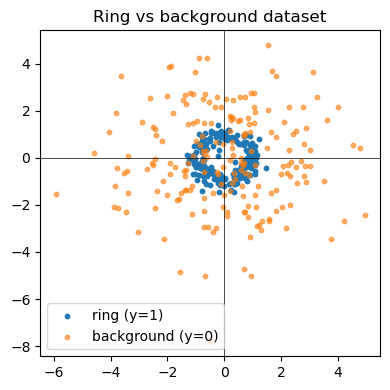

Saved figure: figs/adaptive_relu_2D_data.png


In [3]:

plt.figure(figsize=(4,4))
plt.scatter(X[y==1,0], X[y==1,1], s=10, label="ring (y=1)")
plt.scatter(X[y==0,0], X[y==0,1], s=10, label="background (y=0)", alpha=0.6)
plt.axhline(0, color="k", linewidth=0.5)
plt.axvline(0, color="k", linewidth=0.5)
plt.legend()
plt.title("Ring vs background dataset")
plt.tight_layout()
fname = os.path.join(FIG_DIR, "adaptive_relu_2D_data.png")
plt.savefig(fname, dpi=200)
plt.show()
print("Saved figure:", fname)



## 2. Tiny ReLU Network in 2D


In [4]:

def relu(z: np.ndarray) -> np.ndarray:
    return np.maximum(0.0, z)

def sigmoid(z: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-z))

class TinyReLU2D:
    # Minimal 2D -> hidden_size ReLU -> 1 classifier.
    def __init__(self, hidden_size: int, rng: np.random.Generator = None):
        if rng is None:
            rng = np.random.default_rng()
        self.hidden_size = hidden_size
        self.W1 = rng.normal(scale=0.5, size=(2, hidden_size))
        self.b1 = np.zeros(hidden_size)
        self.W2 = rng.normal(scale=0.5, size=(hidden_size,))
        self.b2 = 0.0

    def forward(self, X: np.ndarray):
        z1 = X @ self.W1 + self.b1
        h1 = relu(z1)
        logits = h1 @ self.W2 + self.b2
        probs = sigmoid(logits)
        cache = {"X": X, "z1": z1, "h1": h1, "logits": logits, "probs": probs}
        return probs, cache

    def binary_cross_entropy(self, probs: np.ndarray, y: np.ndarray) -> float:
        eps = 1e-8
        return -np.mean(y * np.log(probs + eps) + (1 - y) * np.log(1 - probs + eps))

    def compute_grads(self, cache: Dict[str, np.ndarray], y: np.ndarray):
        X = cache["X"]
        z1 = cache["z1"]
        h1 = cache["h1"]
        probs = cache["probs"]
        N = X.shape[0]

        dlogits = (probs - y) / N
        dW2 = h1.T @ dlogits
        db2 = np.sum(dlogits)

        dh1 = np.outer(dlogits, self.W2)
        dz1 = dh1 * (z1 > 0).astype(float)

        dW1 = X.T @ dz1
        db1 = np.sum(dz1, axis=0)

        grads = {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2}
        return grads



## 3. Adaptive Optimizers


In [5]:

class AdaGradOptimizer:
    def __init__(self, model: TinyReLU2D, lr: float = 0.1, eps: float = 1e-8):
        self.lr = lr
        self.eps = eps
        self.G = {
            "W1": np.zeros_like(model.W1),
            "b1": np.zeros_like(model.b1),
            "W2": np.zeros_like(model.W2),
            "b2": np.zeros_like(model.b2),
        }

    def step(self, model: TinyReLU2D, grads: Dict[str, np.ndarray]):
        for name, g in grads.items():
            self.G[name] += g * g
            model_param = getattr(model, name)
            adjusted_lr = self.lr / (np.sqrt(self.G[name]) + self.eps)
            setattr(model, name, model_param - adjusted_lr * g)


class RMSPropOptimizer:
    def __init__(self, model: TinyReLU2D, lr: float = 0.01, beta: float = 0.9, eps: float = 1e-8):
        self.lr = lr
        self.beta = beta
        self.eps = eps
        self.G = {
            "W1": np.zeros_like(model.W1),
            "b1": np.zeros_like(model.b1),
            "W2": np.zeros_like(model.W2),
            "b2": np.zeros_like(model.b2),
        }

    def step(self, model: TinyReLU2D, grads: Dict[str, np.ndarray]):
        for name, g in grads.items():
            self.G[name] = self.beta * self.G[name] + (1 - self.beta) * (g * g)
            model_param = getattr(model, name)
            adjusted_lr = self.lr / (np.sqrt(self.G[name]) + self.eps)
            setattr(model, name, model_param - adjusted_lr * g)


class AdamOptimizer:
    def __init__(self, model: TinyReLU2D, lr: float = 0.01,
                 beta1: float = 0.9, beta2: float = 0.999, eps: float = 1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = {
            "W1": np.zeros_like(model.W1),
            "b1": np.zeros_like(model.b1),
            "W2": np.zeros_like(model.W2),
            "b2": np.zeros_like(model.b2),
        }
        self.v = {
            "W1": np.zeros_like(model.W1),
            "b1": np.zeros_like(model.b1),
            "W2": np.zeros_like(model.W2),
            "b2": np.zeros_like(model.b2),
        }
        self.t = 0

    def step(self, model: TinyReLU2D, grads: Dict[str, np.ndarray]):
        self.t += 1
        for name, g in grads.items():
            self.m[name] = self.beta1 * self.m[name] + (1 - self.beta1) * g
            self.v[name] = self.beta2 * self.v[name] + (1 - self.beta2) * (g * g)
            m_hat = self.m[name] / (1 - self.beta1 ** self.t)
            v_hat = self.v[name] / (1 - self.beta2 ** self.t)
            model_param = getattr(model, name)
            step = self.lr * m_hat / (np.sqrt(v_hat) + self.eps)
            setattr(model, name, model_param - step)



## 4. Training Helpers and Decision Boundary Visualization


In [6]:

def accuracy(probs: np.ndarray, y: np.ndarray, threshold: float = 0.5) -> float:
    preds = (probs >= threshold).astype(int)
    return np.mean(preds == y)

def train_model(
    hidden_size: int,
    optimizer_name: str,
    X_train: np.ndarray,
    y_train: np.ndarray,
    num_epochs: int = 2000,
    lr: float = 0.01,
    seed: int = 0
):
    rng = np.random.default_rng(seed)
    model = TinyReLU2D(hidden_size=hidden_size, rng=rng)

    if optimizer_name == "adagrad":
        opt = AdaGradOptimizer(model, lr=lr)
    elif optimizer_name == "rmsprop":
        opt = RMSPropOptimizer(model, lr=lr)
    elif optimizer_name == "adam":
        opt = AdamOptimizer(model, lr=lr)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    losses = []
    for epoch in range(num_epochs):
        probs, cache = model.forward(X_train)
        loss = model.binary_cross_entropy(probs, y_train)
        grads = model.compute_grads(cache, y_train)
        opt.step(model, grads)
        losses.append(loss)
    return model, np.array(losses)

def plot_decision_boundary(model: TinyReLU2D, X: np.ndarray, y: np.ndarray,
                           title: str, fname: str,
                           grid_lim: float = 3.0, grid_res: int = 200):
    xx, yy = np.meshgrid(
        np.linspace(-grid_lim, grid_lim, grid_res),
        np.linspace(-grid_lim, grid_lim, grid_res)
    )
    grid = np.stack([xx.ravel(), yy.ravel()], axis=1)
    probs, _ = model.forward(grid)
    Z = probs.reshape(xx.shape)

    plt.figure(figsize=(4,4))
    cs = plt.contourf(xx, yy, Z, levels=np.linspace(0,1,21), alpha=0.7)
    plt.colorbar(cs, label="P(y=1|x)")
    plt.contour(xx, yy, Z, levels=[0.5], colors="k", linewidths=2)
    plt.scatter(X[y==1,0], X[y==1,1], s=10, c="white", edgecolors="k", label="ring (y=1)")
    plt.scatter(X[y==0,0], X[y==0,1], s=10, c="black", edgecolors="w", label="background (y=0)", alpha=0.7)
    plt.axhline(0, color="k", linewidth=0.5)
    plt.axvline(0, color="k", linewidth=0.5)
    plt.title(title)
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.show()
    print("Saved figure:", fname)



## 5. Comparing AdaGrad, RMSProp, and Adam for \(H=2\)


Training with adagrad...
Training with rmsprop...
Training with adam...


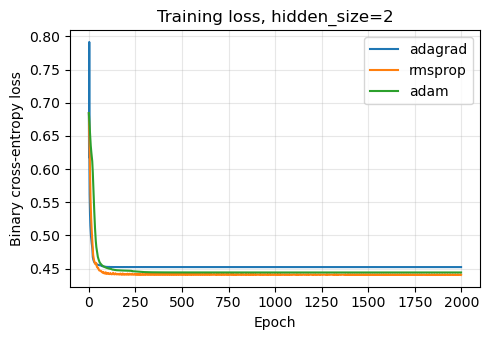

Saved figure: figs/adaptive_relu_2D_H2_losses.png


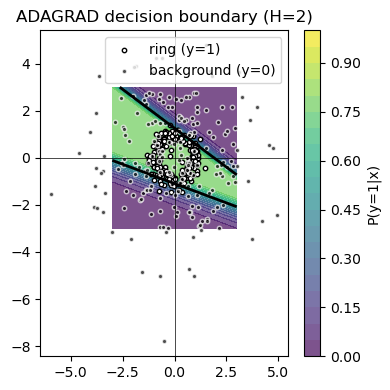

Saved figure: figs/adaptive_relu_2D_H2_adagrad_decision.png


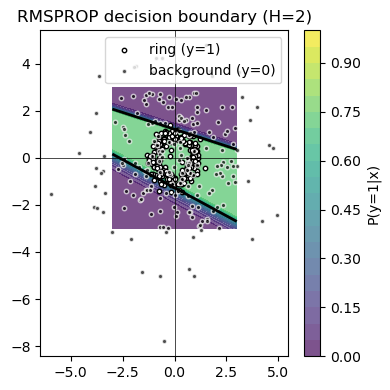

Saved figure: figs/adaptive_relu_2D_H2_rmsprop_decision.png


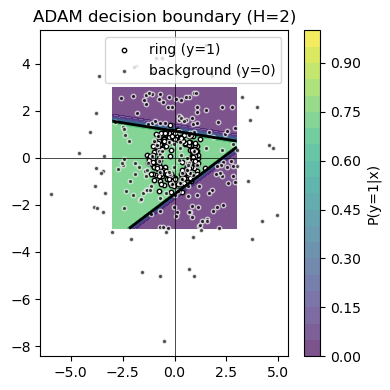

Saved figure: figs/adaptive_relu_2D_H2_adam_decision.png


In [9]:

hidden_size = 2
num_epochs = 2000

results = {}
for opt_name, lr in [("adagrad", 0.5), ("rmsprop", 0.05), ("adam", 0.05)]:
    print(f"Training with {opt_name}...")
    model, losses = train_model(
        hidden_size=hidden_size,
        optimizer_name=opt_name,
        X_train=X,
        y_train=y,
        num_epochs=num_epochs,
        lr=lr,
        seed=0
    )
    probs, _ = model.forward(X)
    acc = accuracy(probs, y)
    results[opt_name] = {"model": model, "losses": losses, "acc": acc}

plt.figure(figsize=(5,3.5))
for opt_name, res in results.items():
    plt.plot(res["losses"], label=f"{opt_name}")
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy loss")
plt.title(f"Training loss, hidden_size={hidden_size}")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
fname_loss = os.path.join(FIG_DIR, f"adaptive_relu_2D_H{hidden_size}_losses.png")
plt.savefig(fname_loss, dpi=200)
plt.show()
print("Saved figure:", fname_loss)

for opt_name, res in results.items():
    fname_db = os.path.join(FIG_DIR, f"adaptive_relu_2D_H{hidden_size}_{opt_name}_decision.png")
    title = f"{opt_name.upper()} decision boundary (H={hidden_size})"
    plot_decision_boundary(res["model"], X, y, title, fname_db)



## 6. Increasing Width: Triangle → Polygon → Almost Circle



Training RMSProp model with hidden_size=2...


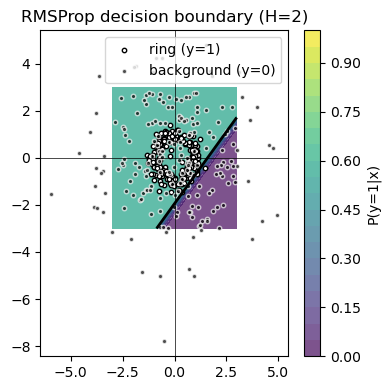

Saved figure: figs/adaptive_relu_2D_H2_RMSProp_decision.png

Training RMSProp model with hidden_size=4...


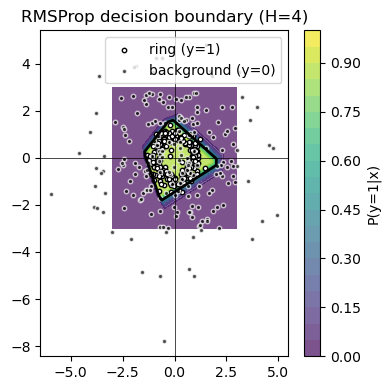

Saved figure: figs/adaptive_relu_2D_H4_RMSProp_decision.png

Training RMSProp model with hidden_size=8...


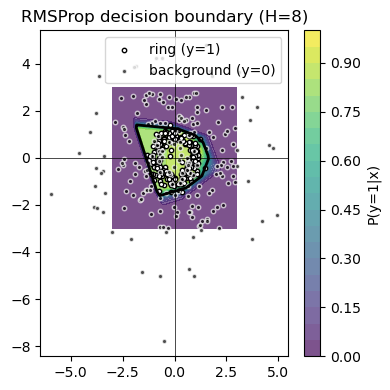

Saved figure: figs/adaptive_relu_2D_H8_RMSProp_decision.png

Training RMSProp model with hidden_size=32...


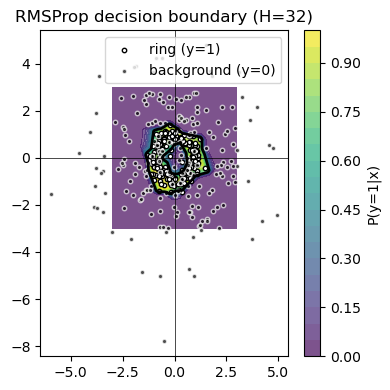

Saved figure: figs/adaptive_relu_2D_H32_RMSProp_decision.png


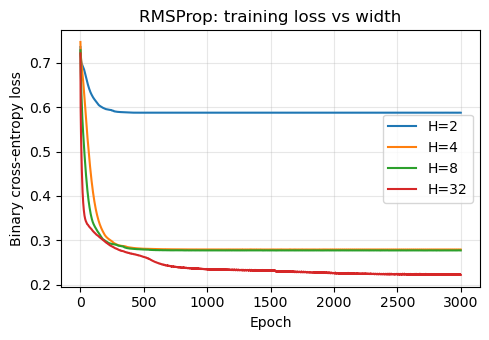

Saved figure: figs/adaptive_relu_2D_RMSProp_losses_vs_width.png


In [10]:

widths = [2, 4, 8, 32]
num_epochs = 3000
opt_name = "rmsprop"
lr = 0.01

models_by_width = {}
for H in widths:
    print(f"\nTraining RMSProp model with hidden_size={H}...")
    model, losses = train_model(
        hidden_size=H,
        optimizer_name=opt_name,
        X_train=X,
        y_train=y,
        num_epochs=num_epochs,
        lr=lr,
        seed=1
    )
    probs, _ = model.forward(X)
    acc = accuracy(probs, y)
    models_by_width[H] = {"model": model, "losses": losses, "acc": acc}

    fname_db = os.path.join(FIG_DIR, f"adaptive_relu_2D_H{H}_RMSProp_decision.png")
    title = f"RMSProp decision boundary (H={H})"
    plot_decision_boundary(model, X, y, title, fname_db)

plt.figure(figsize=(5,3.5))
for H in widths:
    losses = models_by_width[H]["losses"]
    plt.plot(losses, label=f"H={H}")
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy loss")
plt.title("RMSProp: training loss vs width")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
fname_loss_w = os.path.join(FIG_DIR, "adaptive_relu_2D_RMSProp_losses_vs_width.png")
plt.savefig(fname_loss_w, dpi=200)
plt.show()
print("Saved figure:", fname_loss_w)



## 7. Exercise: Exploring Optimizers and Capacity on a Non-Convex Landscape

Extend this notebook to:

1. Compare all three optimizers for larger widths (e.g., \(H=8\) and \(H=32\)).
2. Study learning rate sensitivity for a fixed width and optimizer.
3. Analyze random initialization effects (different seeds).
4. Quantify how the boundary approaches a circle for large \(H\), e.g., by sampling points on the ring
   and evaluating the classifier.

These experiments connect directly to the discussion of **adaptive methods** and **non-convex optimization**
in the chapter.
